In [1]:
import pandas as pd
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Helper only for grouping similar names, not renaming
def normalize_key(col):
    c = col.strip().lower()
    c = c.replace("_", "").replace("-", "").replace(" ", "")
    return c

# List all CSV files
csv_files = [file for file in os.listdir('.') if file.endswith('.csv')]

# Read files
dataframes = {file: pd.read_csv(file) for file in csv_files}

# Mapping: normalized_key -> set(raw spellings)
normalized_to_raw = {}
for file, df in dataframes.items():
    for raw_col in df.columns:
        key = normalize_key(raw_col)
        if key not in normalized_to_raw:
            normalized_to_raw[key] = set()
        normalized_to_raw[key].add(raw_col)

# Full normalized column set
all_normalized_cols = set(normalized_to_raw.keys())

# Summary collectors
summary_missing = {}
summary_spelling = {}
summary_duplicates = {}      # <-- NEW
summary_row_counts = {}      # optional but useful
summary_column_counts = {}   # optional but useful

# Main loop
for file, df in dataframes.items():
    print(f"\n### {file}\n")

    row_count = len(df)
    col_count = len(df.columns)

    summary_row_counts[file] = row_count
    summary_column_counts[file] = col_count

    print(f"Number of rows: {row_count}")
    print(f"Number of columns: {col_count}")

    # Spelling issues
    spelling_issues = []
    for raw_col in df.columns:
        key = normalize_key(raw_col)
        variants = normalized_to_raw.get(key, set())
        other_spellings = sorted(list(variants - {raw_col}))
        if other_spellings:
            spelling_issues.append((raw_col, other_spellings))

    if spelling_issues:
        print("\nColumns with different spellings in other files:")
        for raw, others in spelling_issues:
            print(f"  This file uses '{raw}', others use: {others}")
        summary_spelling[file] = spelling_issues
    else:
        print("\nNo spelling differences for this file.")

    # Missing columns check
    file_norm_keys = {normalize_key(c) for c in df.columns}
    missing_keys = all_normalized_cols - file_norm_keys

    if missing_keys:
        print("\nColumns missing from this file:")
        missing_list = []
        for key in missing_keys:
            print(f"  Missing logical column '{key}' represented in other files as: {list(normalized_to_raw[key])}")
            missing_list.append(key)
        summary_missing[file] = missing_list
    else:
        print("\nNo missing columns for this file.")

    # Head
    print("\nHead:")
    print(df.head().to_markdown(index=False))

    # Info
    print("\nData Types / Info:")
    df.info()
    print()

    # Describe
    print("Describe:")
    try:
        print(df.describe().to_markdown())
    except:
        print("No numeric columns to describe.")

    # Duplicates
    dup_count = df.duplicated().sum()
    if dup_count > 0:
        print(f"\nDuplicate rows: {dup_count}")
        summary_duplicates[file] = dup_count
    else:
        print("\nNo duplicate rows.")

# ================================
# FINAL SUMMARY REPORT
# ================================

print("\n\n================ FINAL SUMMARY ================\n")

# Row count summary
print("Row Counts per File:")
for file, count in summary_row_counts.items():
    print(f"- {file}: {count} rows")

print("\nColumn Counts per File:")
for file, count in summary_column_counts.items():
    print(f"- {file}: {count} columns")

# Missing columns summary
print("\n\nFiles Missing Columns:")
if summary_missing:
    for file, missing in summary_missing.items():
        detailed = {key: list(normalized_to_raw[key]) for key in missing}
        print(f"- {file} → missing: {detailed}")
else:
    print("None")

# Spelling difference summary
print("\nFiles With Spelling Differences:")
if summary_spelling:
    for file, issues in summary_spelling.items():
        print(f"- {file}:")
        for raw, others in issues:
            print(f"    '{raw}' differs from: {others}")
else:
    print("None")

# Duplicate summary  <-- NEW
print("\nFiles With Duplicate Rows:")
if summary_duplicates:
    for file, dups in summary_duplicates.items():
        print(f"- {file}: {dups} duplicate rows")
else:
    print("No duplicate rows found in any file.")

print("\n=============== END OF SUMMARY ===============")



### events_20250223.csv

Number of rows: 4070
Number of columns: 7

Columns with different spellings in other files:
  This file uses 'client_id', others use: ['clientId']

No missing columns for this file.

Head:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                | event_name   |   event_data | user_agent                                                                                                                                         |
|:------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------|:-------------------------|:-------------|-------------:|:--

In [2]:
# Known issues from Step 0
files_with_clientId = [
    'events_20250227.csv', 'events_20250228.csv', 'events_20250301.csv',
    'events_20250302.csv', 'events_20250303.csv', 'events_20250304.csv',
    'events_20250305.csv', 'events_20250306.csv', 'events_20250307.csv',
    'events_20250308.csv'
]

files_missing_referrer = [
    'events_20250304.csv', 'events_20250305.csv', 'events_20250306.csv',
    'events_20250307.csv', 'events_20250308.csv'
]

duplicate_file = "events_20250308.csv"

cleaned_files = {}
csv_files = [file for file in os.listdir('.') if file.endswith('.csv')]

all_columns_standardized = None

for file in csv_files:
    df = pd.read_csv(file)
    print(f"\n\n==================== Cleaning {file} ====================")

    # Fix known spelling issue
    if file in files_with_clientId and "clientId" in df.columns:
        df.rename(columns={"clientId": "client_id"}, inplace=True)
        print("Corrected spelling: clientId to client_id")

    # Add missing referrer column
    if file in files_missing_referrer and "referrer" not in df.columns:
        df["referrer"] = None
        print("Added missing column: referrer")

    # Remove duplicates
    if file == duplicate_file:
        before = len(df)
        df = df.drop_duplicates()
        after = len(df)
        print(f"Rows before duplicate removal: {before}")
        print(f"Rows after duplicate removal:  {after}")

    # Collect unified schema
    if all_columns_standardized is None:
        all_columns_standardized = set(df.columns)
    else:
        all_columns_standardized.update(df.columns)

    # Print head
    print("\nHead:")
    print(df.head().to_markdown(index=False))

    # Print info
    print("\nInfo:")
    df.info()
    print()

    cleaned_files[file] = df

# Schema verification
print("\n\n==================== SCHEMA VERIFICATION ====================\n")

print("Unified schema after fixes:")
print(sorted(all_columns_standardized))
print()

for file, df in cleaned_files.items():
    print(f"\n--- {file} ---")

    # Column count
    print(f"Column count: {len(df.columns)}")

    # Missing columns check
    missing = all_columns_standardized - set(df.columns)
    if missing:
        print(f"Missing columns: {missing}")
    else:
        print("All required columns are present")

    # Incorrect spelling check
    wrong_names = [c for c in df.columns if c.lower() == "clientid"]
    if wrong_names:
        print(f"Incorrect column names still present: {wrong_names}")
    else:
        print("No incorrect column names remain")

print("\nSchema verification is complete.\n")




==================== Cleaning events_20250223.csv ====================

Head:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                | event_name   |   event_data | user_agent                                                                                                                                         |
|:------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------|:-------------------------|:-------------|-------------:|:-----------------------------------------------------------------------------------------------------------------------------------------

In [3]:
# Step 2: Merge all cleaned DataFrames and clean nulls

required_cols = ["client_id", "timestamp", "event_name"]

# merge all cleaned DataFrames from previous step
merged_df = pd.concat(cleaned_files.values(), ignore_index=True)

print("Total rows before null cleaning:", len(merged_df))

print("\nNull counts in required columns:")
print(merged_df[required_cols].isnull().sum())

# drop rows with nulls in required critical columns
cleaned_merged_df = merged_df.dropna(subset=required_cols)

print("\nTotal rows after removing nulls:", len(cleaned_merged_df))

# duplicate check AFTER merge
dup_count_before = cleaned_merged_df.duplicated().sum()
print("\nDuplicate rows detected after merge (before removal):", dup_count_before)

if dup_count_before > 0:
    rows_before = len(cleaned_merged_df)
    cleaned_merged_df = cleaned_merged_df.drop_duplicates()
    rows_after = len(cleaned_merged_df)
    dup_count_after = cleaned_merged_df.duplicated().sum()

    print("Rows before duplicate removal:", rows_before)
    print("Rows after duplicate removal:", rows_after)
    print("Duplicate rows detected after removal:", dup_count_after)
else:
    print("No duplicate rows found after merge.")

# preview
print("\nHead of merged cleaned dataset:")
print(cleaned_merged_df.head().to_markdown(index=False))

print("\nInfo after cleaning:")
cleaned_merged_df.info()
print()

# save output for next steps
cleaned_merged_df.to_csv("events_merged_cleaned.csv", index=False)
print("Merged and cleaned dataset saved as events_merged_cleaned.csv")



Total rows before null cleaning: 97016

Null counts in required columns:
client_id     2908
timestamp        0
event_name       0
dtype: int64

Total rows after removing nulls: 94108

Duplicate rows detected after merge (before removal): 47054
Rows before duplicate removal: 94108
Rows after duplicate removal: 47054
Duplicate rows detected after removal: 0

Head of merged cleaned dataset:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                | event_name   |   event_data | user_agent                                                                                                                                         |
|:------------------------|:-------------------------------------------------------------------------------------------------------------------

In [4]:
from urllib.parse import urlparse, parse_qs
import json

# Work directly on cleaned_merged_df
df = cleaned_merged_df

print("Starting Step 3: Splitting timestamp and inspecting parameters...\n")

# 1) Convert timestamp and extract new time columns
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

df["event_date"] = df["timestamp"].dt.date
df["event_time"] = df["timestamp"].dt.time
df["event_hour"] = df["timestamp"].dt.hour
df["event_weekday"] = df["timestamp"].dt.day_name()

print("Timestamp successfully split into event_date, event_time, event_hour, event_weekday.\n")

# 2) Inspect URL query parameters
print("Inspecting all URL parameters present in page_url...\n")

all_url_params = set()

for url in df["page_url"].astype(str):
    query = parse_qs(urlparse(url).query)
    for p in query.keys():
        all_url_params.add(p)

print("Detected URL parameters:")
print(all_url_params)
print("Total parameters detected:", len(all_url_params), "\n")

# 3) Inspect event_data JSON keys
print("Inspecting keys inside event_data...\n")

event_keys = set()

for raw in df["event_data"].astype(str):
    try:
        obj = json.loads(raw)
        for key in obj.keys():
            event_keys.add(key)
    except:
        continue

print("Detected event_data keys:")
print(event_keys)
print("Total keys detected:", len(event_keys), "\n")

# 4) Inspect user_agent examples
print("Sample user_agent values:")
print(df["user_agent"].head(5), "\n")

# 5) Confirm datatypes after timestamp conversion
print("Data types after timestamp and inspection:")
df.info()

print("\nStep 3 inspection complete. No extraction or row removals performed.")


Starting Step 3: Splitting timestamp and inspecting parameters...

Timestamp successfully split into event_date, event_time, event_hour, event_weekday.

Inspecting all URL parameters present in page_url...

Detected URL parameters:
{'step', 'auto_show_edge_shopping_flyout', 'locale', 'ml___id', 'cto_pld', 'product', 'main', 'imp_sku', 'sn', 'bedframe', 'srsltid', 'gad', 'gclid', 'ny', '_rsc', '_ke', 'clickid', 'gqt', 'utm_campaign', 'variation', 'button', 'epik', 'awc', 'im_rewards', 'utm_term', 'sleepingPosition', '_kx', 'preview_theme_id', 'amp_device_id', 'talkable_visitor_uuid', 'kind', 'sub4', 'country', 'wtbap', 'irclickid', 'set_view', 'msclkid', 'optimizely_x_audiences', 'page', 'utm_medium', 'com_cvv', 'gad_source', 'optimizely_x', 'optimizely_token', 'ad_id', 'completed', 'c_token', 'view', 'variant', 'edge_redirect', 'offer', 'optimizely_preview_layer_ids', 'su', 'ml___url_share_action', 'rf', 'subid1', 'ml___task', 'reload_receipt', '2', 'bxid', 'mattress', 'color', 'media_

In [5]:
import re
import json
from urllib.parse import urlparse, parse_qs

print("Starting Step 4: Extracting URL params, JSON fields, items, UA parts, browser, and item dimensions...\n")

# ------------------------------------------------------
# 0) Work on a clean copy
# ------------------------------------------------------
df_ext = cleaned_merged_df.copy()


# ======================================================
# 1) JSON SANITIZATION HELPERS
# ======================================================

def clean_json_string(raw):
    """Cleans malformed JSON input by removing parentheses and semicolons."""
    if raw is None:
        return None
    s = str(raw).strip()

    if s.startswith("(") and s.endswith(")"):
        s = s[1:-1].strip()
    if s.endswith(";"):
        s = s[:-1].strip()

    return s


def load_json(raw):
    """Safe JSON loading after sanitization."""
    try:
        cleaned = clean_json_string(raw)
        return json.loads(cleaned)
    except:
        return None


# ======================================================
# 2) URL PARAMETER EXTRACTION
# ======================================================
utm_params = ["utm_source", "utm_medium", "utm_campaign", "utm_content", "utm_term"]
ad_params = ["gclid", "fbclid", "msclkid", "wbraid", "gbraid"]
product_params = ["product", "mattress", "feel", "size", "color", "variant"]
checkout_params = ["cart_id", "checkout_queue_token"]

all_url_params = utm_params + ad_params + product_params + checkout_params

def extract_param(url, key):
    try:
        return parse_qs(urlparse(str(url)).query).get(key, [None])[0]
    except:
        return None

# extract all except product (handled separately)
for p in all_url_params:
    if p == "product":
        continue
    df_ext[p] = df_ext["page_url"].apply(lambda x: extract_param(x, p))


# ======================================================
# 2B) CORRECT PRODUCT SLUG FROM URL PATH
# ======================================================
def extract_product_from_url(url):
    if not isinstance(url, str):
        return None

    u = url.lower()

    if "/products/" not in u:
        return None

    slug = u.split("/products/")[1]
    slug = slug.split("?")[0]
    slug = slug.split("/")[0]
    slug = re.sub(r'[^a-zA-Z0-9\-\_]', "", slug)

    return slug if slug else None

df_ext["product"] = df_ext["page_url"].apply(extract_product_from_url)


# ======================================================
# 3) EVENT-LEVEL JSON FIELDS
# ======================================================
event_fields = ["transaction_id", "user_email", "revenue", "items"]

for f in event_fields:
    df_ext[f] = df_ext["event_data"].apply(
        lambda x: load_json(x).get(f) if load_json(x) else None
    )


# ======================================================
# 4) ITEM-LEVEL EXTRACTION
# ======================================================
item_fields = ["item_id", "item_name", "item_variant", "quantity", "item_price"]

def extract_item_field(raw, key):
    obj = load_json(raw)
    if not obj:
        return None

    items = obj.get("items")
    if isinstance(items, list) and len(items) > 0:
        return items[0].get(key)

    return None

for col in item_fields:
    df_ext[col] = df_ext["event_data"].apply(lambda x: extract_item_field(x, col))


# ======================================================
# 4B) SPLIT item_variant INTO TYPE, SIZE, WIDTH, LENGTH, HEIGHT
# ======================================================
def parse_item_variant(v):
    if not isinstance(v, str):
        return (None, None, None, None, None)

    # Extract type and size from the left part
    variant_main = v.split("-")[0].strip()
    if "/" in variant_main:
        item_type = variant_main.split("/")[0].strip()
        item_size = variant_main.split("/")[1].strip()
    else:
        item_type = None
        item_size = None

    # Extract dimensions allowing decimals (critical fix)
    width_match = re.search(r'(\d+(?:\.\d+)?)"\s*[Ww]', v)
    length_match = re.search(r'(\d+(?:\.\d+)?)"\s*[Ll]', v)
    height_match = re.search(r'(\d+(?:\.\d+)?)"\s*[Hh]', v)

    width = width_match.group(1) if width_match else None
    length = length_match.group(1) if length_match else None
    height = height_match.group(1) if height_match else None  # FIXED

    return (item_type, item_size, width, length, height)

df_ext[["item_type", "item_size", "dim_width_in", "dim_length_in", "dim_height_in"]] = \
    df_ext["item_variant"].apply(lambda x: pd.Series(parse_item_variant(x)))


# ======================================================
# 5) USER-AGENT TOKEN SPLITTING
# ======================================================
def clean_ua_token(token):
    if token is None:
        return None
    t = str(token).strip()

    t = re.sub(r'^[\(\[\{\"\'\s]+', "", t)
    t = re.sub(r'[\)\]\}\"\'\;\,\s]+$', "", t)

    return t

ua_split = df_ext["user_agent"].astype(str).str.split(" ")

df_ext["ua_part1"] = ua_split.str[0].apply(clean_ua_token)
df_ext["ua_part2"] = ua_split.str[1].apply(clean_ua_token)
df_ext["ua_part3"] = ua_split.str[2].apply(clean_ua_token)


# ======================================================
# 6) CLEAN BROWSER IDENTIFICATION
# ======================================================
def extract_clean_browser(ua):
    if not isinstance(ua, str):
        return None

    ua_l = ua.lower()

    if "chrome/" in ua_l and "edg/" not in ua_l:
        return "Chrome"
    if "safari/" in ua_l and "chrome/" not in ua_l:
        return "Safari"
    if "firefox/" in ua_l:
        return "Firefox"
    if "edg/" in ua_l:
        return "Edge"
    if "ddg" in ua_l or "duckduckgo" in ua_l:
        return "DuckDuckGo"
    if "opr/" in ua_l or "opera" in ua_l:
        return "Opera"

    return "Other"

df_ext["browser"] = df_ext["user_agent"].apply(extract_clean_browser)


# ======================================================
# 7) PREVIEW
# ======================================================
print(df_ext.head(100).to_markdown(index=False))

print("\nData types after extraction:")
df_ext.info()

print("\nStep 4 complete: All fields extracted successfully, including corrected height parsing.\n")




Starting Step 4: Extracting URL params, JSON fields, items, UA parts, browser, and item dimensions...

| client_id               | page_url                                                                                                                                                                                                                                                                                                                            | referrer                                                                                                        | timestamp                        | event_name            | event_data                                                                                                                                                                                                                                                                                                   | user_agent                                                         

In [6]:
# Step 5: Rename UA parts + ad ids + product fields directly on df_ext

rename_map = {
    # User-Agent meaningful names
    "ua_part1": "ua_engine",          # e.g., Mozilla/5.0
    "ua_part2": "ua_device_token",    
    "ua_part3": "ua_os_token",       

    # Ad identifiers
    "gclid": "google_click_id",
    "fbclid": "facebook_click_id",
    "msclkid": "microsoft_click_id",
    "wbraid": "google_wbraid",
    "gbraid": "google_gbraid",

    # Product / merchandising parameters
    "product": "product_type",
    "mattress": "mattress_type",
    "feel": "product_feel",
    "size": "product_size",
    "color": "product_color",
    "variant": "product_variant",

    # Checkout identifiers
    "cart_id": "checkout_cart_id",
    "checkout_queue_token": "checkout_queue_token",

    # Event-level JSON fields
    "transaction_id": "transaction_id",
    "user_email": "user_email",
    "revenue": "revenue",
    "items": "items",

    # Item-level extracted fields
    "item_id": "item_id",
    "item_name": "item_name",
    "item_variant": "item_variant",
    "quantity": "item_quantity",
    "item_price": "item_price",

    # Browser column
    "browser": "browser"
}

# Apply renaming directly
df_ext.rename(columns=rename_map, inplace=True)

# PREVIEW
print("### df_ext head (first 10 rows):")
print(df_ext.head(10).to_markdown(index=False))

print("\n### df_ext.info():")
df_ext.info()


### df_ext head (first 10 rows):
| client_id               | page_url                                                                                                                                                                                                                                                                      | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                                                                         | event_date   | event_time      |   event_hour | event_weekday   | utm_source   | utm_medium   | utm_campaign   | utm_content   | utm_term   | google_click_id   | facebook_click_id   | microsoft_click_id   | google_wbraid   | google_gbraid   | mattress_type   | product_feel   | product_size   | product_color   | product_variant   | checkout_cart_id   | checkout_queue_token   | product_type           | transaction_id   |

In [7]:
# Step 6: Categorical Sampling for Unification Check

categorical_cols = [
    "product_type", 
    "product_feel",
    "product_size",
    "product_color",
    "product_variant",
    "user_email",
    "item_name",
    "item_variant",
    "event_name",
    "event_data",
    "ua_os_token",
    "browser",
    "ua_device_token",
    "ua_engine"
]

print("\nStarting Step 6: Categorical Sampling...\n")

for col in categorical_cols:
    if col not in df_ext.columns:
        print(f"\nColumn '{col}' not found in df_ext — skipping.")
        continue

    print(f"\n==============================")
    print(f"Categorical Sampling for: {col}")
    print("==============================")

    unique_vals = df_ext[col].dropna().unique()
    unique_count = len(unique_vals)

    print(f"Total unique values: {unique_count}")

    if unique_count > 50:
        top50 = (
            df_ext[col]
            .value_counts(dropna=True)
            .head(50)
            .index
            .tolist()
        )
        print("Top 50 most frequent values:")
        print(top50)
    else:
        print("All unique values:")
        print(unique_vals)



Starting Step 6: Categorical Sampling...


Categorical Sampling for: product_type
Total unique values: 39
All unique values:
['puffy-mattress' 'puffy-topper' 'puffy-lux-mattress'
 'puffy-monarch-mattress' 'puffy-bed-frame' 'puffy-adjustable-base'
 'puffy-royal-mattress' 'puffy-blanket' 'puffy-sheets'
 'puffy-zen-bed-frame' 'puffy-foundation' 'puffy-monarch-smart-bed-set'
 'puffy-pillow' 'puffy-lux-smart-bed-set' 'puffy-weighted-blanket'
 'puffy-mattress-protector' 'puffy-dusk-bed-frame'
 'puffy-mattress-vs-purple' 'puffy-comforter' 'puffy-cloud-smart-bed-set'
 'puffy-royal-smart-bed-set' 'puffy-mattress-pad' 'puffy-sectional-sofa'
 'puffy-area-rug' 'puffy-royal-mattresss' 'puffy-sleep-mask'
 'puffy-lux-mattress_kx4bqho-f4gydddatvsbwtzqkn3hwrkindback-pain'
 'puffy-cloud-mattress-cooling'
 'puffy-mattress_kxiq1dyvavnr1e9hqev7xqpezrp3s6atp6qqwja0594dukn3hwr'
 'puffy-lux-mattress_kxzwvxhwsxs_rte8ftyghjwy0he9zyjjouae8jnsabtu0kn3hwr'
 'puffy-lux-mattress_kxckfeyttkeuqe9ckw9xeihmevu-_xieiswo

In [8]:
print("\nStarting Step 5: Category Unification...\n")

# =========================================================
# 1) PRODUCT TYPE CLEANING  (use the correct column name!)
# =========================================================

valid_products = {
    "puffy-mattress", "puffy-lux-mattress", "puffy-monarch-mattress",
    "puffy-royal-mattress", "puffy-topper", "puffy-blanket",
    "puffy-weighted-blanket", "puffy-sheets", "puffy-pillow",
    "puffy-comforter", "puffy-mattress-protector", "puffy-mattress-pad",
    "puffy-bed-frame", "puffy-zen-bed-frame", "puffy-dusk-bed-frame",
    "puffy-foundation", "puffy-adjustable-base", "puffy-sectional-sofa",
    "puffy-area-rug", "puffy-cloud-mattress", "puffy-cloud-smart-bed-set",
    "puffy-monarch-smart-bed-set", "puffy-lux-smart-bed-set",
    "puffy-royal-smart-bed-set", "puffy-signature-sleep-mask",
    "puffy-deluxe-mattress-pad", "cover-puffy-lux"
}

def clean_product_type(p):
    if p is None or str(p).lower() == "nan":
        return None

    p = str(p).lower().strip()

    # Remove hash suffix like: puffy-lux-mattress_kx92d0...
    if "_" in p:
        p = p.split("_")[0]

    # Fix typos
    if p == "puffy-royal-mattresss":
        return "puffy-royal-mattress"
    if p == "puffy-monarch-mattress22":
        return "puffy-monarch-mattress"

    # We treat weird slugs pointing to blogs/content pages
    if "vs" in p or "review" in p or "comparison" in p:
        return "content-page"

    if p in valid_products:
        return p

    return "unknown_product"

df_ext["product_type_clean"] = df_ext["product_type"].apply(clean_product_type)


# =========================================================
# 2) OS TOKEN NORMALIZATION
# =========================================================

def clean_os_token(os):
    if os is None:
        return "Other"
    os = str(os).strip()

    mapping = {
        "NT": "Windows",
        "CPU": "iOS",
        "Intel": "macOS",
        "Android": "Android",
        "Linux": "Linux",
        "Ubuntu": "Linux",
        "CrOS": "ChromeOS",
        "NetCast": "SmartTV",
        "PlayStation": "PlayStationOS"
    }

    return mapping.get(os, "Other")

df_ext["ua_os_clean"] = df_ext["ua_os_token"].apply(clean_os_token)


# =========================================================
# 3) DEVICE TOKEN NORMALIZATION
# =========================================================

def clean_device_token(dev):
    if dev is None:
        return "Other"
    dev = str(dev).strip()

    mapping = {
        "iPhone": "iPhone",
        "iPad": "iPad",
        "Macintosh": "Mac",
        "Windows": "Windows",
        "Android": "Android",
        "Linux": "Linux",
        "X11": "Linux Desktop",
        "Mobile": "Mobile",
        "SMART-TV": "SmartTV",
        "PlayStation": "PlayStation"
    }

    return mapping.get(dev, "Other")

df_ext["ua_device_clean"] = df_ext["ua_device_token"].apply(clean_device_token)


# =========================================================
# 4) ENGINE TOKEN NORMALIZATION
# =========================================================

def clean_engine_token(e):
    if e is None:
        return "Other"

    e = str(e).strip()

    mapping = {
        "Mozilla/5.0": "Mozilla",
        "facebookexternalhit/1.1": "FacebookBot",
        "Instagram": "InstagramBot",
        "AdsBot-Google": "GoogleAdsBot",
        "msnbot/1.1": "MSNBot"
    }

    return mapping.get(e, "Other")

df_ext["ua_engine_clean"] = df_ext["ua_engine"].apply(clean_engine_token)


# =========================================================
# 5) PREVIEW
# =========================================================

print("Unified dataset preview:")
print(df_ext[[
    "product_type", "product_type_clean",
    "ua_os_token", "ua_os_clean",
    "ua_device_token", "ua_device_clean",
    "ua_engine", "ua_engine_clean",
    "browser"
]].head(10).to_markdown(index=False))

print("\nData types after unification:")
df_ext.info()

print("\nStep 5 complete: categorical unification applied to df_ext.")




Starting Step 5: Category Unification...

Unified dataset preview:
| product_type           | product_type_clean     | ua_os_token   | ua_os_clean   | ua_device_token   | ua_device_clean   | ua_engine   | ua_engine_clean   | browser   |
|:-----------------------|:-----------------------|:--------------|:--------------|:------------------|:------------------|:------------|:------------------|:----------|
|                        |                        | NT            | Windows       | Windows           | Windows           | Mozilla/5.0 | Mozilla           | Chrome    |
| puffy-mattress         | puffy-mattress         | CPU           | iOS           | iPhone            | iPhone            | Mozilla/5.0 | Mozilla           | Safari    |
| puffy-topper           | puffy-topper           | CPU           | iOS           | iPhone            | iPhone            | Mozilla/5.0 | Mozilla           | Safari    |
|                        |                        | CPU           | iOS           

In [9]:
print("\nStarting final cleanup step...\n")

# =========================================================
# 1) PRODUCT COLOR FIXES (map special codes -> names)
# =========================================================

color_map = {
    "4E8723": "Dark Green",
    "5AEA7C": "Light Green",
    "94B526": "Yellow",
    "994AE1": "Purple",
    "4689DD": "Blue"
}

def clean_product_color(val):
    if val is None or str(val).lower() == "nan":
        return None
    v = str(val).strip().upper()
    return color_map.get(v, v)

if "product_color" in df_ext.columns:
    df_ext["product_color"] = df_ext["product_color"].apply(clean_product_color)


# =========================================================
# 2) DROP INCORRECT / BROKEN COLUMNS
# =========================================================

cols_to_drop = [
    "mattress",
    "feel",
    "size",
    "user_email",
    "ua_os_token",
    "ua_device_token",
    "ua_engine"
]

df_ext = df_ext.drop(columns=[c for c in cols_to_drop if c in df_ext.columns])


# =========================================================
# 3) RENAME CLEANED COLUMNS TO FINAL NAMES
#    (and drop the *_clean versions)
# =========================================================

# product_type_clean -> product_type
if "product_type_clean" in df_ext.columns:
    df_ext["product_type"] = df_ext["product_type_clean"]
    df_ext = df_ext.drop(columns=["product_type_clean"])

# ua_os_clean -> ua_os
if "ua_os_clean" in df_ext.columns:
    df_ext["ua_os"] = df_ext["ua_os_clean"]
    df_ext = df_ext.drop(columns=["ua_os_clean"])

# ua_device_clean -> ua_device
if "ua_device_clean" in df_ext.columns:
    df_ext["ua_device"] = df_ext["ua_device_clean"]
    df_ext = df_ext.drop(columns=["ua_device_clean"])

# ua_engine_clean -> ua_engine
if "ua_engine_clean" in df_ext.columns:
    df_ext["ua_engine"] = df_ext["ua_engine_clean"]
    df_ext = df_ext.drop(columns=["ua_engine_clean"])

# If we had created product_color_clean earlier, use it and drop it
if "product_color_clean" in df_ext.columns:
    df_ext["product_color"] = df_ext["product_color_clean"]
    df_ext = df_ext.drop(columns=["product_color_clean"])


# =========================================================
# 4) DUPLICATE CHECK (EXCLUDING LIST-LIKE `items` COLUMN)
# =========================================================

subset_cols = [c for c in df_ext.columns if c != "items"]

total_rows = len(df_ext)
dup_mask = df_ext.duplicated(subset=subset_cols)
duplicate_rows = dup_mask.sum()

print(f"Total rows in df_ext: {total_rows}")
print(f"Total duplicated rows (excluding 'items' column in comparison): {duplicate_rows}")

if duplicate_rows > 0:
    print("\nPreview of duplicate rows:")
    print(df_ext[dup_mask].head().to_markdown(index=False))
else:
    print("\nNo duplicated rows found.")


# =========================================================
# 5) FINAL PREVIEW
# =========================================================

print("\nUpdated df_ext preview:")
print(df_ext.head(10).to_markdown(index=False))

print("\nColumns in updated df_ext:")
print(df_ext.columns.tolist())

print("\nData types in updated df_ext:")
df_ext.info()

print("\nFinal cleanup step complete.")



Starting final cleanup step...

Total rows in df_ext: 47054
Total duplicated rows (excluding 'items' column in comparison): 0

No duplicated rows found.

Updated df_ext preview:
| client_id               | page_url                                                                                                                                                                                                                                                                      | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                                                                         | event_date   | event_time      |   event_hour | event_weekday   | utm_source   | utm_medium   | utm_campaign   | utm_content   | utm_term   | google_click_id   | facebook_click_id   | microsoft_click_id   | google_wbraid   | google_gbraid   | mattress_type   | product_feel   

In [10]:
import numpy as np

numeric_cols = [
    "item_quantity",
    "item_price",
    "revenue",
    "dim_width_in",
    "dim_length_in",
    "dim_height_in",
    "item_size"   
]

for col in numeric_cols:
    print(f"\nGoogle 3A Check for: {col}")
    print("----------------------------------------")

    # Convert everything to raw string FIRST (CRITICAL FIX)
    raw_series = df_ext[col].astype(str)

    # Apply original Google 3A formula
    mask_invalid = pd.to_numeric(raw_series, errors="coerce").isna()
    invalid_values = raw_series[mask_invalid].unique()

    # Print results properly
    if len(invalid_values) > 20:
        print(np.random.choice(invalid_values, 20, replace=False))
    else:
        print(invalid_values)




Google 3A Check for: item_quantity
----------------------------------------
['nan']

Google 3A Check for: item_price
----------------------------------------
['nan']

Google 3A Check for: revenue
----------------------------------------
['nan']

Google 3A Check for: dim_width_in
----------------------------------------
['None']

Google 3A Check for: dim_length_in
----------------------------------------
['None']

Google 3A Check for: dim_height_in
----------------------------------------
['None']

Google 3A Check for: item_size
----------------------------------------
['None' 'Queen' 'Twin XL' 'King' 'Cal King' 'Twin' 'Full' 'Medium']


In [11]:
dim_cols = ["dim_width_in", "dim_length_in", "dim_height_in"]  # ← added item_size

for col in dim_cols:
    print(f"Applying Google 2A for: {col}")

    # Step 1: Convert to string
    s = df_ext[col].astype(str).str.strip()

    # Step 2: Replace EXACT "None" only
    s = s.replace({"None": ""})

    # Step 3: Remove standalone dots ".", "..", "..."
    s = s.replace({".": "", "..": "", "...": ""})

    # Step 4: Convert to numeric (Google 2A)
    df_ext[col] = pd.to_numeric(s, errors="coerce")

    # Output
    print("Unique numeric values:", df_ext[col].dropna().unique()[:15])
    print("Final dtype:", df_ext[col].dtype)
    print("-" * 50)

print("\nHead after Google 2A cleaning:")
print(df_ext.head().to_markdown(index=False))

print("\nInfo after Google 2A cleaning:")
df_ext.info()




Applying Google 2A for: dim_width_in
Unique numeric values: [60. 72. 38. 76. 48. 54. 64. 94. 80. 81. 39. 90.]
Final dtype: float64
--------------------------------------------------
Applying Google 2A for: dim_length_in
Unique numeric values: [ 80.  84.  75.  72.  88. 108.  85.  94.]
Final dtype: float64
--------------------------------------------------
Applying Google 2A for: dim_height_in
Unique numeric values: [ 2.5 12.  14.  10.  51.  16.  14.5 13.4 15.   2. ]
Final dtype: float64
--------------------------------------------------

Head after Google 2A cleaning:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                           

In [12]:
print("Starting Direct Date/Time Conversion...\n")

# Convert event_date to datetime64 (invalid become NaT automatically)
df_ext["event_date"] = pd.to_datetime(df_ext["event_date"], errors="coerce")

# Convert event_time to time object
_temp = pd.to_datetime(df_ext["event_time"], errors="coerce")
df_ext["event_time"] = _temp.dt.time

print("Direct conversion applied.\n")

print("Preview after conversion:")
print(df_ext.head().to_markdown(index=False))

print("\nData types after conversion:")
df_ext.info()


Starting Direct Date/Time Conversion...

Direct conversion applied.

Preview after conversion:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                                                                         | event_date          | event_time   |   event_hour | event_weekday   | utm_source   | utm_medium   | utm_campaign   | utm_content   | utm_term   | google_click_id   | facebook_click_id   | microsoft_click_id   | google_wbraid   | google_gbraid   | mattress_type   | product_feel   | product_size   | product_color   | product_variant   | checkout_cart_id   | checkout_queue_token   | product_type   | transaction_id   |   revenue | 

In [13]:
# =========================================================
# FINAL DATA QUALITY FRAMEWORK
# Detect issues, identify IDs/dates, add final bad-data flag
# Does NOT remove any rows. Preserves entire dataset.
# =========================================================

df = df_ext.copy()


# ---------------------------------------------------------
# 1) Invalid event_date (outside Feb 23 – Mar 8, 2025)
# ---------------------------------------------------------

expected_start = pd.Timestamp("2025-02-23")
expected_end   = pd.Timestamp("2025-03-08")

def flag_bad_date(d):
    if pd.isna(d):
        return "Y"
    if d < expected_start or d > expected_end:
        return "Y"
    return "N"

df["flag_invalid_event_date"] = df["event_date"].apply(flag_bad_date)


# ---------------------------------------------------------
# 2) checkout_completed but revenue missing/zero
# ---------------------------------------------------------

def flag_missing_rev_checkout(row):
    en  = row.get("event_name")
    rev = row.get("revenue")

    if not isinstance(en, str):
        return "N"
    if en.strip().lower() != "checkout_completed":
        return "N"
    if pd.isna(rev) or rev in [None, "", 0]:
        return "Y"
    return "N"

df["flag_missing_revenue_checkout"] = df.apply(flag_missing_rev_checkout, axis=1)


# ---------------------------------------------------------
# 3) Revenue exists but event is not checkout_completed
# ---------------------------------------------------------

def flag_rev_on_wrong_event(row):
    en  = row.get("event_name")
    rev = row.get("revenue")

    if pd.isna(rev) or rev in [None, "", 0]:
        return "N"
    if not isinstance(en, str):
        return "Y"
    if en.strip().lower() != "checkout_completed":
        return "Y"
    return "N"

df["flag_revenue_on_non_checkout"] = df.apply(flag_rev_on_wrong_event, axis=1)


# ---------------------------------------------------------
# 4) transaction_id exists but revenue missing/zero
# ---------------------------------------------------------

def flag_trans_without_rev(row):
    tid = row.get("transaction_id")
    rev = row.get("revenue")

    if tid in [None, "", float("nan")]:
        return "N"
    if pd.isna(rev) or rev in [None, "", 0]:
        return "Y"
    return "N"

df["flag_transactionid_no_revenue"] = df.apply(flag_trans_without_rev, axis=1)


# ---------------------------------------------------------
# 5) Duplicate transaction_id (flag only — not used for bad data)
# ---------------------------------------------------------

tid_counts = df["transaction_id"].value_counts(dropna=True)
duplicate_tids = tid_counts[tid_counts > 1].index

df["flag_duplicate_transaction_id"] = df["transaction_id"].apply(
    lambda x: "Y" if x in duplicate_tids else "N"
)


# ---------------------------------------------------------
# 6) Missing timestamp
# ---------------------------------------------------------

df["flag_missing_timestamp"] = df["timestamp"].apply(
    lambda t: "Y" if pd.isna(t) else "N"
)


# ---------------------------------------------------------
# 7) Missing event_name
# ---------------------------------------------------------

df["flag_missing_event_name"] = df["event_name"].apply(
    lambda x: "Y" if not isinstance(x, str) or x.strip() == "" else "N"
)


# ---------------------------------------------------------
# 8) Missing client_id
# ---------------------------------------------------------

df["flag_missing_client_id"] = df["client_id"].apply(
    lambda x: "Y" if pd.isna(x) or x in ["", None] else "N"
)


# ---------------------------------------------------------
# 9) page_viewed but page_url missing
# ---------------------------------------------------------

def flag_missing_page_for_view(row):
    en = row.get("event_name")
    if isinstance(en, str) and en.lower() == "page_viewed":
        url = row.get("page_url")
        if pd.isna(url) or url in ["", None]:
            return "Y"
    return "N"

df["flag_missing_page_url_on_view"] = df.apply(flag_missing_page_for_view, axis=1)


# ---------------------------------------------------------
# 10) Suspicious timestamp (future or too old)
# ---------------------------------------------------------

now = pd.Timestamp.now(tz="UTC")
min_valid_ts = pd.Timestamp("2020-01-01", tz="UTC")

def flag_suspicious_ts(t):
    if pd.isna(t):
        return "N"
    if t.tzinfo is None:
        t = t.tz_localize("UTC")
    if t > now:
        return "Y"
    if t < min_valid_ts:
        return "Y"
    return "N"

df["flag_suspicious_timestamp"] = df["timestamp"].apply(flag_suspicious_ts)


# ---------------------------------------------------------
# 11) UTM fields present but blank
# ---------------------------------------------------------

utm_cols = ["utm_source", "utm_medium", "utm_campaign", "utm_content", "utm_term"]

def flag_bad_utm(row):
    for c in utm_cols:
        val = row.get(c)
        if isinstance(val, str) and val.strip() == "":
            return "Y"
    return "N"

df["flag_empty_utm_fields"] = df.apply(flag_bad_utm, axis=1)


# ---------------------------------------------------------
# 12) Invalid user_agent
# ---------------------------------------------------------

def flag_bad_user_agent(ua):
    if not isinstance(ua, str):
        return "Y"
    if len(ua) < 20:
        return "Y"
    return "N"

df["flag_invalid_user_agent"] = df["user_agent"].apply(flag_bad_user_agent)


# =========================================================
# FINAL CONSOLIDATED BAD QUALITY FLAG
# (duplicate transactions excluded)
# =========================================================

flags_used_for_bad_quality = [
    "flag_invalid_event_date",
    "flag_missing_revenue_checkout",
    "flag_revenue_on_non_checkout",
    "flag_transactionid_no_revenue",
    "flag_missing_timestamp",
    "flag_missing_event_name",
    "flag_missing_client_id",
    "flag_missing_page_url_on_view",
    "flag_suspicious_timestamp",
    "flag_empty_utm_fields",
    "flag_invalid_user_agent"
]

df["flag_bad_data"] = df[flags_used_for_bad_quality].apply(
    lambda row: "Y" if "Y" in row.values else "N",
    axis=1
)

df["bad_quality_row"] = df["flag_bad_data"]


# =========================================================
# COUNTS FOR EACH FLAG
# =========================================================

print("\nFlag counts:\n")
for col in flags_used_for_bad_quality + ["flag_duplicate_transaction_id", "flag_bad_data"]:
    print(f"{col}: { (df[col] == 'Y').sum() }")


# =========================================================
# IDENTIFY PROBLEMATIC IDS AND DAYS (NO REMOVAL)
# =========================================================

print("\nMissing revenue on checkout_completed:")
print(df[df["flag_missing_revenue_checkout"] == "Y"][[
    "timestamp", "event_date", "transaction_id", "client_id", "revenue"
]].sort_values("timestamp").to_markdown(index=False))

print("\nTransactions with ID but no revenue:")
print(df[df["flag_transactionid_no_revenue"] == "Y"][[
    "timestamp", "event_date", "transaction_id", "client_id", "revenue"
]].sort_values("timestamp").to_markdown(index=False))

print("\nDuplicate transaction IDs:")
print(df[df["flag_duplicate_transaction_id"] == "Y"]["transaction_id"].unique())

print("\nRows belonging to duplicated transaction IDs:")
print(df[df["flag_duplicate_transaction_id"] == "Y"][[
    "timestamp", "event_date", "transaction_id", "client_id", "revenue"
]].sort_values(["transaction_id", "timestamp"]).to_markdown(index=False))

print("\nInvalid user_agent rows:")
print(df[df["flag_invalid_user_agent"] == "Y"][[
    "timestamp", "event_date", "client_id", "user_agent"
]].to_markdown(index=False))

print("\nIssue summary per event_date:")
summary = df.groupby("event_date")[flags_used_for_bad_quality].apply(lambda x: (x == "Y").sum())
print(summary.to_markdown())







Flag counts:

flag_invalid_event_date: 0
flag_missing_revenue_checkout: 10
flag_revenue_on_non_checkout: 0
flag_transactionid_no_revenue: 10
flag_missing_timestamp: 0
flag_missing_event_name: 0
flag_missing_client_id: 0
flag_missing_page_url_on_view: 0
flag_suspicious_timestamp: 0
flag_empty_utm_fields: 0
flag_invalid_user_agent: 2
flag_duplicate_transaction_id: 8
flag_bad_data: 12

Missing revenue on checkout_completed:
| timestamp                        | event_date          | transaction_id   | client_id               |   revenue |
|:---------------------------------|:--------------------|:-----------------|:------------------------|----------:|
| 2025-02-24 13:44:44.348000+00:00 | 2025-02-24 00:00:00 | ORD-20250224-227 | 1740404510-RR2JJVeKrqEa |         0 |
| 2025-02-25 13:28:11.878000+00:00 | 2025-02-25 00:00:00 | ORD-20250225-246 | 1740235155-Iyyo-PYeYrfN |         0 |
| 2025-02-27 15:00:58.313000+00:00 | 2025-02-27 00:00:00 | ORD-20250227-314 | 1740668179-BpHiz-xV96as |       

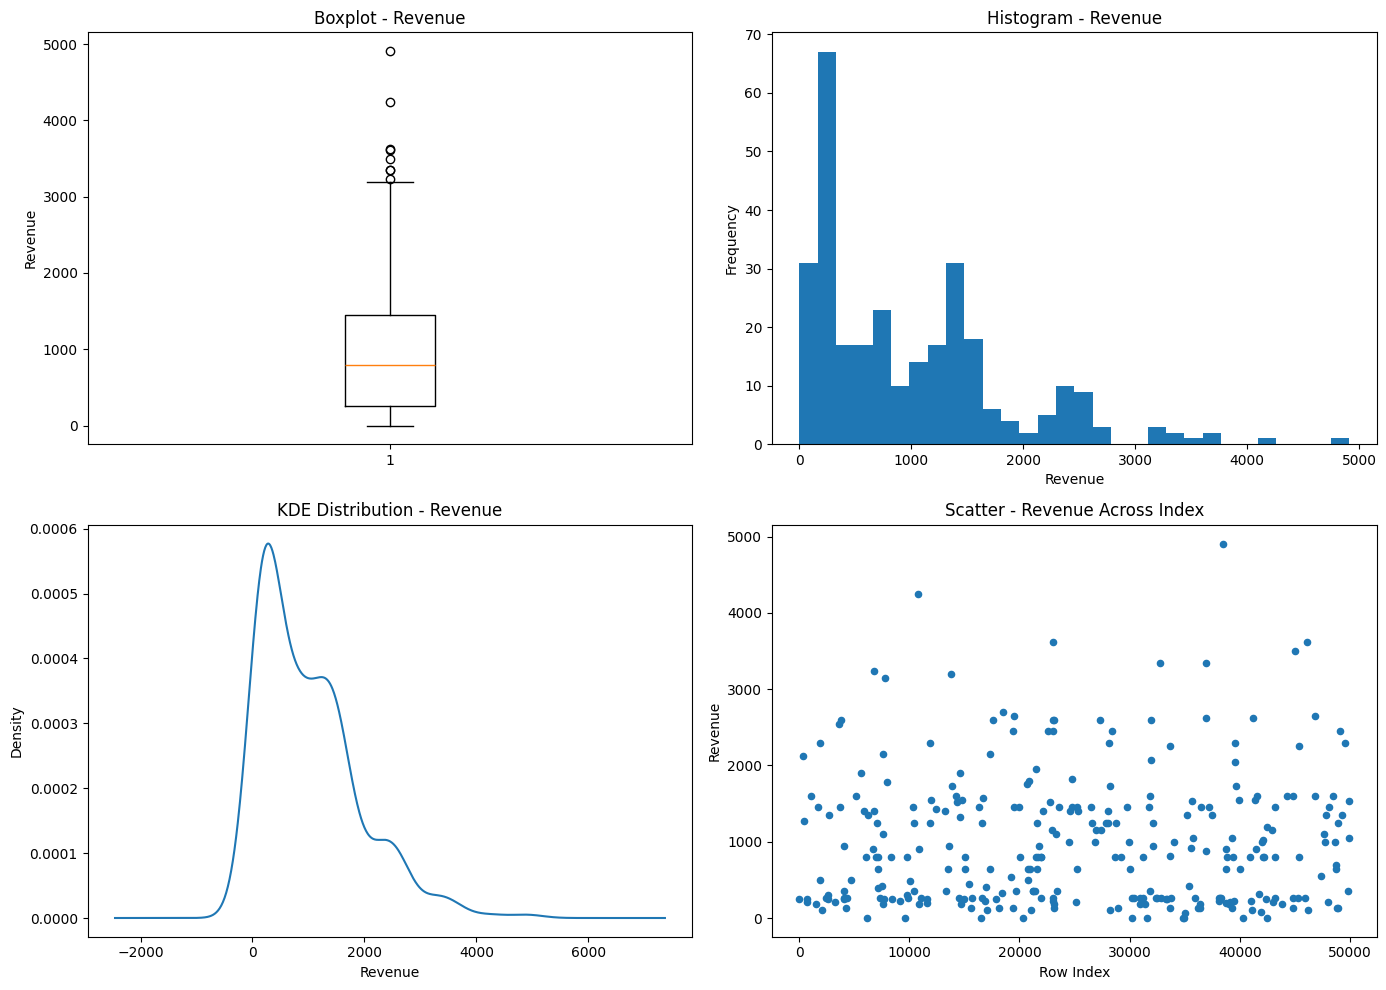

In [14]:
import matplotlib.pyplot as plt

# ---- Select the revenue column ----
rev = df_ext["revenue"]

# ---- Create figure space ----
plt.figure(figsize=(14, 10))

# ---------------------------
# 1) BOX PLOT
# ---------------------------
plt.subplot(2, 2, 1)
plt.boxplot(rev.dropna(), vert=True)
plt.title("Boxplot - Revenue")
plt.ylabel("Revenue")

# ---------------------------
# 2) HISTOGRAM
# ---------------------------
plt.subplot(2, 2, 2)
plt.hist(rev.dropna(), bins=30)
plt.title("Histogram - Revenue")
plt.xlabel("Revenue")
plt.ylabel("Frequency")

# ---------------------------
# 3) KDE / DISTRIBUTION
# ---------------------------
plt.subplot(2, 2, 3)
rev.dropna().plot(kind="kde")
plt.title("KDE Distribution - Revenue")
plt.xlabel("Revenue")

# ---------------------------
# 4) SCATTER PLOT (INDEX vs VALUE)
# ---------------------------
plt.subplot(2, 2, 4)
plt.scatter(rev.index, rev, s=20)
plt.title("Scatter - Revenue Across Index")
plt.xlabel("Row Index")
plt.ylabel("Revenue")

# -------- Show all plots --------
plt.tight_layout()
plt.show()


In [15]:
# =========================================================
# CREATE CLEAN DATAFRAME FOR DATA WAREHOUSE
# Drops ONLY rows marked as bad quality (Y)
# =========================================================

df_clean = df[df["flag_bad_data"] == "N"].copy()

print("\nRows before cleaning:", len(df))
print("Rows after cleaning:", len(df_clean))
print("Rows removed:", len(df) - len(df_clean))

print("\nClean dataframe head:\n")
print(df_clean.head().to_markdown(index=False))

print("\nClean dataframe info:\n")
print(df_clean.info())




Rows before cleaning: 47054
Rows after cleaning: 47042
Rows removed: 12

Clean dataframe head:

| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                                                                         | event_date          | event_time   |   event_hour | event_weekday   | utm_source   | utm_medium   | utm_campaign   | utm_content   | utm_term   | google_click_id   | facebook_click_id   | microsoft_click_id   | google_wbraid   | google_gbraid   | mattress_type   | product_feel   | product_size   | product_color   | product_variant   | checkout_cart_id   | checkout_queue_token   | product_type   | transaction_id   |   revenue 

In [16]:
# =========================================================
# CREATE FINAL CLEAN DATAFRAME (GOOD ROWS ONLY)
# =========================================================

# Keep only rows without bad data
df_clean = df[df["flag_bad_data"] == "N"].copy()

print("\nRows before cleaning:", len(df))
print("Rows after cleaning:", len(df_clean))
print("Rows removed:", len(df) - len(df_clean))


# =========================================================
# DROP UNUSED COLUMNS IN THE CLEAN DATA
# =========================================================

cols_to_drop = ["product_feel", "product_size"]

df_clean = df_clean.drop(columns=cols_to_drop, errors="ignore")

print("\nDropped columns:", cols_to_drop)


# =========================================================
# SHOW CLEANED DATAFRAME (HEAD + INFO)
# =========================================================

print("\nClean dataframe head:")
print(df_clean.head().to_markdown(index=False))

print("\nClean dataframe info:")
df_clean.info()



Rows before cleaning: 47054
Rows after cleaning: 47042
Rows removed: 12

Dropped columns: ['product_feel', 'product_size']

Clean dataframe head:
| client_id               | page_url                                                                                                                                                                                               | referrer                     | timestamp                        | event_name   |   event_data | user_agent                                                                                                                                         | event_date          | event_time   |   event_hour | event_weekday   | utm_source   | utm_medium   | utm_campaign   | utm_content   | utm_term   | google_click_id   | facebook_click_id   | microsoft_click_id   | google_wbraid   | google_gbraid   | mattress_type   | product_color   | product_variant   | checkout_cart_id   | checkout_queue_token   | product_type   | transaction_i